# End-To-End Train and Deploy Machine Learning Model on Kubernetes

Using:

 * kubeflow
 * seldon-core
 
 
Follow the main README to setup, train and deploy your model. This notebook will show how to run the Argo jobs and example prediction calls to the deployed models.

**To run this notebook you will need to install Tensorflow**
 
The example will be the MNIST handwriiten digit classification task.

![MNIST](mnist.png "MNIST Digits")

# Setup

Set kubectl to use the namespace where you installed kubeflow and seldon. In the README it is kubeflow-seldon

In [1]:
!kubectl config set-context $(kubectl config current-context) --namespace=kubeflow-seldon

Context "gke_mnist-classification3_us-east1-d_kubeflow-seldon-ml" modified.


In [1]:
import sys
sys.path.append('proto')

# Submit tensorflow training job


In [2]:
!argo submit ../workflows/training-tf-mnist-workflow.yaml -p tfjob-version-hack=$RANDOM

Name:             kubeflow-tf-train-xrmqb
Namespace:        kubeflow-seldon
ServiceAccount:   default
Status:           Pending
Created:          Tue Apr 10 15:55:42 -0300 (27 seconds ago)
Parameters:       
  tfjob-version-hack: 31071
  version:        0.1
  github-user:    kubeflow
  github-revision: master
  docker-user:    seldonio
  build-push-image: false


In [22]:
!argo list

NAME                      STATUS      AGE    DURATION
kubeflow-sk-train-gq8m9   Succeeded   7m     6m 
kubeflow-tf-train-xrmqb   Succeeded   12m    2m 


# Serve tensorflow model


In [35]:
!kubectl apply -f ../k8s_serving/serving_model.json

seldondeployment "mnist-classifier" configured


# Submit scikit-learn training job


In [13]:
!argo submit ../workflows/training-sk-mnist-workflow.yaml

Name:             kubeflow-sk-train-gq8m9
Namespace:        kubeflow-seldon
ServiceAccount:   default
Status:           Pending
Created:          Tue Apr 10 16:00:21 -0300 (26 seconds ago)
Parameters:       
  version:        0.1
  github-user:    kubeflow
  github-revision: master
  docker-user:    seldonio
  build-push-image: false


# Serve scikit-learn model


In [37]:
!argo submit ../workflows/serving-sk-mnist-workflow.yaml

Name:             seldon-sk-deploy-6k2kv
Namespace:        kubeflow-seldon
ServiceAccount:   default
Status:           Pending
Created:          Tue Apr 10 16:38:54 -0300 (now)
Parameters:       
  version:        0.1
  github-user:    SeldonIO
  github-revision: master
  docker-user:    seldonio
  build-push-image: false


# Mnist Setup
You will need Tensorflow installed to run this section.

In [24]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
def gen_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(two_d,cmap=plt.cm.gray_r, interpolation='nearest')
    return plt

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


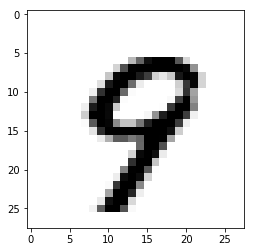

In [25]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
batch_xs, batch_ys = mnist.train.next_batch(10)
gen_image(batch_xs[1]).show()

Create proto files for gRPC. You will need [python grpc tools](https://grpc.io/docs/quickstart/python.html) installed

In [29]:
!python -m grpc.tools.protoc -I. --python_out=. --grpc_python_out=. ./proto/prediction.proto

In [30]:
import requests
from requests.auth import HTTPBasicAuth
from random import randint,random
from proto import prediction_pb2
from proto import prediction_pb2_grpc
import grpc
import json
from visualizer import get_graph

AMBASSADOR_API_IP="localhost:8002"

def rest_request(deploymentName,request):
    response = requests.post(
                "http://"+AMBASSADOR_API_IP+"/seldon/"+deploymentName+"/api/v0.1/predictions",
                json=request)
    return response.json()   
    
def rest_request_auth(deploymentName,data,username,password):
    payload = {"data":{"ndarray":data.tolist()}}
    response = requests.post(
                "http://"+AMBASSADOR_API_IP+"/seldon/"+deploymentName+"/api/v0.1/predictions",
                json=payload,
                auth=HTTPBasicAuth(username, password))
    print(response.status_code)
    return response.json()   

def grpc_request(deploymentName,data):
    datadef = prediction_pb2.DefaultData(
            names = ["a","b"],
            tensor = prediction_pb2.Tensor(
                shape = [1,784],
                values = data
                )
            )
    request = prediction_pb2.SeldonMessage(data = datadef)
    channel = grpc.insecure_channel(AMBASSADOR_API_IP)
    stub = prediction_pb2_grpc.SeldonStub(channel)
    metadata = [('seldon',deploymentName)]
    response = stub.Predict(request=request,metadata=metadata)
    print(response)

def send_feedback_rest(deploymentName,request,response,reward):
    feedback = {
        "request": request,
        "response": response,
        "reward": reward
    }
    ret = requests.post(
         "http://"+AMBASSADOR_API_IP+"/seldon/"+deploymentName+"/api/v0.1/feedback",
        json=feedback)
    return ret.text


# Get predictions
**Ensure you have port forwarded the ambassador reverse proxy**

```bash
kubectl port-forward $(kubectl get pods -n -l service=ambassador -o jsonpath='{.items[0].metadata.name}') -n  8002:80
```

If the tensorflow model has not been deployed you can directly use the kubernetes manifest for it to deploy

#### REST Request

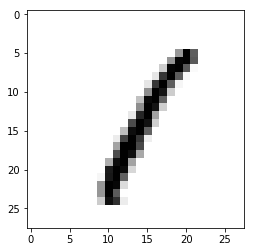

{
  "meta": {
    "puid": "qqbj6inhn14184fiu1pqfh9i5g", 
    "routing": {}, 
    "tags": {}
  }, 
  "data": {
    "names": [
      "class:0", 
      "class:1", 
      "class:2", 
      "class:3", 
      "class:4", 
      "class:5", 
      "class:6", 
      "class:7", 
      "class:8", 
      "class:9"
    ], 
    "ndarray": [
      [
        3.30419766214618e-06, 
        0.987647294998169, 
        0.005178458523005247, 
        0.0013984217075631022, 
        0.00042379790102131665, 
        0.00033390967291779816, 
        0.00014896524953655899, 
        0.0019742075819522142, 
        0.002786459168419242, 
        0.00010512406879570335
      ]
    ]
  }
}
<type 'dict'>
{
  "meta": {
    "puid": "dsqg29fjhs9r4tfr4dep27g6ts", 
    "routing": {}, 
    "tags": {}
  }, 
  "data": {
    "names": [
      "class:0", 
      "class:1", 
      "class:2", 
      "class:3", 
      "class:4", 
      "class:5", 
      "class:6", 
      "class:7", 
      "class:8", 
      "class:9"
    ], 
    

In [38]:
batch_xs, batch_ys = mnist.train.next_batch(1)
chosen=0
gen_image(batch_xs[chosen]).show()
data = batch_xs[chosen].reshape((1,784))
request = {"data":{"ndarray":data.tolist()}}
#trying prediction with tensorflow model
predictions = rest_request("mnist-classifier",request)
print(json.dumps(predictions, indent=2))
#trying prediction with scikit-learn model
predictions = rest_request("mnist-classifier-sk",request)
print type(predictions)
print(json.dumps(predictions, indent=2))

gRPC Request

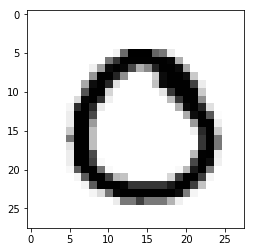

meta {
  puid: "65e17c7dlkqqjono30pk66bsq1"
}
data {
  names: "class:0"
  names: "class:1"
  names: "class:2"
  names: "class:3"
  names: "class:4"
  names: "class:5"
  names: "class:6"
  names: "class:7"
  names: "class:8"
  names: "class:9"
  tensor {
    shape: 1
    shape: 10
    values: 0.995216488838
    values: 5.57943691248e-11
    values: 0.00025496960734
    values: 1.26618579088e-05
    values: 3.59720919718e-09
    values: 0.000556721061002
    values: 1.60381430359e-09
    values: 4.86848648507e-07
    values: 0.00395666295663
    values: 2.03249805963e-06
  }
}



In [7]:
batch_xs, batch_ys = mnist.train.next_batch(1)
chosen=0
gen_image(batch_xs[chosen]).show()
data = batch_xs[chosen].reshape((784))
grpc_request("mnist-classifier",data)